In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

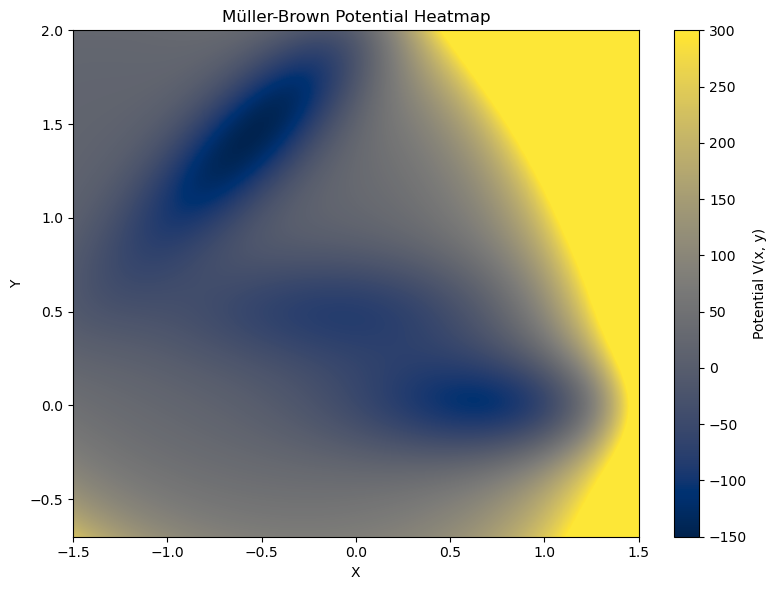

In [2]:

# Define the coefficients
A = np.array([-200.0, -100.0, -170.0, 15.0])
a = np.array([-1.0, -1.0, -6.5, 0.7])
b = np.array([0.0, 0.0, 11.0, 0.6])
c = np.array([-10.0, -10.0, -6.5, 0.7])
x0 = np.array([1.0, 0.0, -0.5, -1.0])
y0 = np.array([0.0, 0.5, 1.5, 1.0])

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownPotential(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    return np.sum(zi)

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dx(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dx = np.sum((2 * a * (x - x0) + b * (y - y0)) * zi)
    return dx

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dy(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dy = np.sum((b * (x - x0) + 2 * c * (y - y0)) * zi)
    return dy

def mullerBrownHeatmap(N, xrange=(-1.5, 1.5), yrange=(-0.7, 2.0)):
    x = np.linspace(*xrange, N)
    y = np.linspace(*yrange, N)
    X, Y = np.meshgrid(x, y)
    Z = mullerBrownPotential(X, Y)
    return X, Y, Z

def mullerBrownPotentialAndGradient(pos):
    return mullerBrownPotential(pos[0], pos[1]), mullerBrownGradient_dx(pos[0], pos[1]), mullerBrownGradient_dy(pos[0], pos[1])


def plot_muller_brown_heatmap(trj = None, cmap='cividis', vmin=-150, vmax=300):
    """
    Plots a heatmap of the Müller-Brown potential with colorbar limits set between vmin and vmax.

    Parameters:
    - X (numpy.ndarray): 2D array of x-coordinates.
    - Y (numpy.ndarray): 2D array of y-coordinates.
    - Z (numpy.ndarray): 2D array of potential values.
    - cmap (str): Colormap for the heatmap. Default is 'plasma'.
    - vmin (float): Minimum value for color scaling. Default is -300.
    - vmax (float): Maximum value for color scaling. Default is 300.
    """
    
    X, Y, Z = mullerBrownHeatmap(500)
    plt.figure(figsize=(8, 6))
    
    # Create the heatmap using imshow with specified vmin and vmax
    # To ensure correct aspect ratio and orientation, we set extent and origin
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = plt.imshow(Z, extent=extent, origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar to show the potential scale
    cbar = plt.colorbar(im)
    cbar.set_label('Potential V(x, y)')

    # Label the axes
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Müller-Brown Potential Heatmap')
    
    if trj is not None:
        plt.plot(*trj.T, c='red', lw=0.1)

    plt.tight_layout()
    plt.show()


plot_muller_brown_heatmap()


In [3]:
#@numba.njit
def velocityVerlet(n, eInit=50.0):

    pos = np.zeros((n, 2))
    conserved = np.zeros(n // 1000)
    pos[0] = np.array([-0.55, 1.44])
    
    u, dudx, dudy = mullerBrownPotentialAndGradient(pos[0])
    
    eKin = eInit - u
    if eKin < 1.0:
        eKin = 1.0
    vInit = np.sqrt(eKin)
    vel = np.zeros(2)
    theta = 2 * np.pi * np.random.rand()
    vel[0] = vInit * np.cos(theta)
    vel[1] = vInit * np.sin(theta)
    print(u, np.sum(vel**2))
    
    dt = 5e-4

    for i in range(n-1):
        pos[i+1] = pos[i] + vel * dt + 0.5 * np.array([-dudx, -dudy]) * dt**2
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        u, dudx, dudy = mullerBrownPotentialAndGradient(pos[i+1])
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        
        if i % 1000 == 0:
            conserved[i//1000] = u + 0.5 * np.sum(vel**2)
    return pos, conserved
    
# @numba.njit
def langevin(n, T=1.0):
    pos = np.zeros((n, 2))
    vel = np.zeros(2)
    pos[0] = np.array([-0.5, 1.2])
    vel = 10.0 * np.random.rand(2)
    u, dudx, dudy = mullerBrownPotentialAndGradient(pos[0])

    dt = 5e-4
    
    gamma = 1.0
    theta = np.exp(-gamma * dt)
    sigma = np.sqrt((1-theta**2) * T)

    for i in range(n-1):
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        vel = theta * vel + sigma * np.random.randn(2)
        
        pos[i+1] = pos[i] + 0.5 * vel * dt
        
        u, dudx, dudy = mullerBrownPotentialAndGradient(pos[i+1])
        
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
    return pos

In [4]:
pos, conserved = langevin(int(1e7), T=12.0)
print((conserved[-1]-conserved[0])/conserved[0])
print(np.mean(conserved[10:]))

ValueError: too many values to unpack (expected 2)

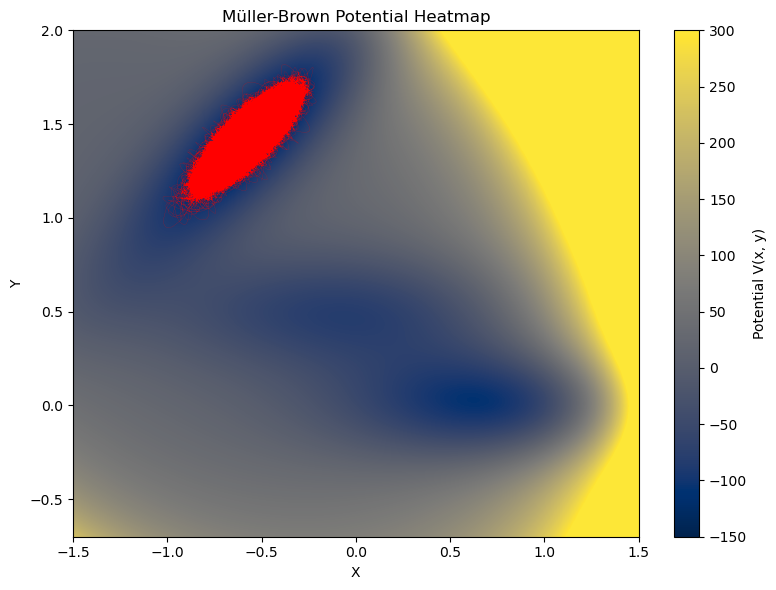

In [ ]:
plot_muller_brown_heatmap(pos, cmap='cividis', vmin=-150, vmax=300)